<a href="https://colab.research.google.com/github/arunangshudutta/DA6401_assignment3/blob/main/Ques_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch.optim as optim
from tqdm import tqdm

import shutil
import pandas as pd

from collections import Counter

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Colab\ Notebooks/DA6401/assignment\ 3/dakshina_dataset_v1.0/hi/lexicons

hi.translit.sampled.dev.tsv   hi.translit.sampled.train.tsv
hi.translit.sampled.test.tsv


In [ ]:
# Source folder in Google Drive
src_folder = '/content/drive/MyDrive/Colab Notebooks/DA6401/assignment 3/dakshina_dataset_v1.0/hi/lexicons'

# Destination in Colab's local storage
dst_folder = '/content/hindi_data'

# Copy the entire folder
shutil.copytree(src_folder, dst_folder)

'/content/hindi_data'

In [ ]:
# Load the data
df_train = pd.read_csv("hindi_data/hi.translit.sampled.train.tsv", sep="\t", header=None, names=["target", "input", "num"])
# Drop rows with NaNs (if any)
df_train = df_train.dropna()

df_val = pd.read_csv("hindi_data/hi.translit.sampled.dev.tsv", sep="\t", header=None, names=["target", "input", "num"])
df_val = df_val.dropna()

df_test = pd.read_csv("hindi_data/hi.translit.sampled.test.tsv", sep="\t", header=None, names=["target", "input", "num"])
df_test = df_val.dropna()

In [ ]:
# Special tokens
PAD_token = "<pad>"
SOS_token = "<sos>"  # start of sequence
EOS_token = "<eos>"  # end of sequence

def build_vocab(sequences):
    vocab = set(char for seq in sequences for char in seq)
    vocab = [PAD_token, SOS_token, EOS_token] + sorted(vocab)
    char2idx = {c: i for i, c in enumerate(vocab)}
    idx2char = {i: c for c, i in char2idx.items()}
    return char2idx, idx2char

input_char2idx, input_idx2char = build_vocab(df_train["input"])
target_char2idx, target_idx2char = build_vocab(df_train["target"])

print(f"Input vocab size: {len(input_char2idx)}")
print(f"Target vocab size: {len(target_char2idx)}")

Input vocab size: 29
Target vocab size: 66


In [ ]:
def encode_sequence(seq, char2idx, add_sos_eos=True):
    tokens = [char2idx[c] for c in seq]
    if add_sos_eos:
        tokens = [char2idx[SOS_token]] + tokens + [char2idx[EOS_token]]
    return tokens

input_sequences = [encode_sequence(seq, input_char2idx) for seq in df_train["input"]]
target_sequences = [encode_sequence(seq, target_char2idx) for seq in df_train["target"]]

input_val = [encode_sequence(seq, input_char2idx) for seq in df_val["input"]]
target_val = [encode_sequence(seq, target_char2idx) for seq in df_val["target"]]


input_test = [encode_sequence(seq, input_char2idx) for seq in df_test["input"]]
target_test = [encode_sequence(seq, target_char2idx) for seq in df_test["target"]]

In [ ]:
class TransliterationDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])

def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=input_char2idx[PAD_token])
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=target_char2idx[PAD_token])
    return inputs_padded, targets_padded

train_dataset = TransliterationDataset(input_sequences, target_sequences)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

val_dataset = TransliterationDataset(input_val, target_val)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

test_dataset = TransliterationDataset(input_test, target_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

In [ ]:
input_char2idx

{'<pad>': 0,
 '<sos>': 1,
 '<eos>': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

In [ ]:
input_test

[[1, 3, 16, 13, 3, 16, 2],
 [1, 3, 16, 9, 13, 17, 20, 2],
 [1, 3, 16, 9, 11, 20, 3, 2],
 [1, 3, 16, 9, 11, 22, 10, 11, 2],
 [1, 3, 16, 9, 20, 7, 12, 2],
 [1, 3, 16, 9, 20, 7, 12, 17, 16, 2],
 [1, 3, 16, 12, 3, 3, 15, 2],
 [1, 3, 16, 12, 3, 15, 2],
 [1, 3, 16, 22, 3, 13, 3, 20, 3, 16, 2],
 [1, 3, 16, 22, 13, 3, 20, 3, 16, 2],
 [1, 3, 16, 20, 3, 14, 17, 16, 2],
 [1, 3, 16, 22, 20, 3, 14, 17, 16, 2],
 [1, 3, 16, 22, 3, 20, 13, 3, 14, 3, 10, 2],
 [1, 3, 16, 22, 3, 20, 13, 14, 3, 10, 2],
 [1, 3, 16, 22, 13, 3, 14, 3, 10, 2],
 [1, 3, 16, 6, 10, 7, 20, 2],
 [1, 3, 16, 6, 10, 7, 20, 3, 2],
 [1, 3, 16, 6, 10, 7, 20, 3, 3, 2],
 [1, 3, 16, 6, 10, 7, 20, 7, 2],
 [1, 3, 15, 4, 3, 20, 2],
 [1, 3, 15, 4, 7, 20, 2],
 [1, 23, 15, 4, 7, 20, 2],
 [1, 3, 15, 4, 3, 20, 16, 3, 22, 10, 2],
 [1, 3, 10, 3, 16, 13, 3, 3, 20, 2],
 [1, 3, 10, 3, 16, 13, 3, 20, 2],
 [1, 3, 16, 10, 13, 3, 20, 2],
 [1, 3, 13, 3, 3, 21, 10, 2],
 [1, 3, 13, 3, 21, 10, 2],
 [1, 3, 13, 7, 7, 14, 3, 3, 2],
 [1, 3, 13, 11, 14, 3, 2],
 [1,

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Flexible Encoder ----
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, num_layers=1, cell_type="RNN", dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        rnn_cell = {"RNN": nn.RNN, "LSTM": nn.LSTM, "GRU": nn.GRU}[cell_type]
        self.rnn = rnn_cell(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.cell_type = cell_type
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        outputs, hidden = self.rnn(embedded)
        return hidden


# ---- Flexible Decoder ----
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, num_layers=1, cell_type="RNN", dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, embed_dim)
        rnn_cell = {"RNN": nn.RNN, "LSTM": nn.LSTM, "GRU": nn.GRU}[cell_type]
        self.rnn = rnn_cell(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.cell_type = cell_type

    def forward(self, input, hidden):
        input = input.unsqueeze(1)  # [B] -> [B,1]
        embedded = self.embedding(input)  # [B,1,E]
        embedded = self.dropout(embedded)
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))  # [B, V]
        return prediction, hidden


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, sos_idx, eos_idx, cell_type="RNN"):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.cell_type = cell_type

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        B, T = trg.shape
        output_dim = self.decoder.fc_out.out_features
        outputs = torch.zeros(B, T, output_dim).to(device)

        hidden = self.encoder(src)
        input = torch.tensor([self.sos_idx] * B).to(device)

        for t in range(T):
            output, hidden = self.decoder(input, hidden)
            outputs[:, t, :] = output

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else output.argmax(1)

        return outputs


# model training

In [ ]:
em_sz = 32
num_lay = 3
hid_sz = 64
cty = "LSTM"
dr = 0.3
lr = 0.01


# Initialize model
encoder = Encoder(len(input_char2idx), embed_dim = em_sz, hidden_dim = hid_sz, num_layers=num_lay, cell_type=cty, dropout=dr).to(device)
decoder = Decoder(len(target_char2idx), embed_dim = em_sz, hidden_dim = hid_sz, num_layers=num_lay, cell_type=cty, dropout=dr).to(device)
model = Seq2Seq(encoder, decoder, sos_idx=target_char2idx['<sos>'], eos_idx=target_char2idx['<eos>'], cell_type=cty).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=target_char2idx["<pad>"])

# Training Loop
for epoch in range(1, 16):
    model.train()
    epoch_loss = 0
    for src, trg in tqdm(train_dataloader):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        output = model(src, trg)  # output: (B, T, V)
        output = output.view(-1, len(target_char2idx))
        trg = trg.view(-1)

        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # --- Validation ---
    model.eval()
    total_tokens = 0
    correct_tokens = 0
    with torch.no_grad():
        for val_src, val_trg in val_dataloader:
            val_src, val_trg = val_src.to(device), val_trg.to(device)
            val_output = model(val_src, val_trg)  # shape: (B, T, V)
            val_pred = val_output.argmax(dim=-1)  # (B, T)

            mask = val_trg != target_char2idx["<pad>"]
            correct = (val_pred == val_trg) & mask
            correct_tokens += correct.sum().item()
            total_tokens += mask.sum().item()

    val_accuracy = correct_tokens / total_tokens * 100

    print(f"Epoch {epoch} | Train Loss: {epoch_loss / len(train_dataloader):.4f} | Val Acc: {val_accuracy:.2f}%")

100%|██████████| 346/346 [00:49<00:00,  6.94it/s]


Epoch 1 | Train Loss: 2.5507 | Val Acc: 40.36%


100%|██████████| 346/346 [00:55<00:00,  6.29it/s]


Epoch 2 | Train Loss: 1.9359 | Val Acc: 52.43%


100%|██████████| 346/346 [00:55<00:00,  6.26it/s]


Epoch 3 | Train Loss: 1.5483 | Val Acc: 60.04%


100%|██████████| 346/346 [00:52<00:00,  6.62it/s]


Epoch 4 | Train Loss: 1.3254 | Val Acc: 64.95%


100%|██████████| 346/346 [00:50<00:00,  6.81it/s]


Epoch 5 | Train Loss: 1.1928 | Val Acc: 67.50%


100%|██████████| 346/346 [00:50<00:00,  6.80it/s]


Epoch 6 | Train Loss: 1.0959 | Val Acc: 69.92%


100%|██████████| 346/346 [00:49<00:00,  6.98it/s]


Epoch 7 | Train Loss: 1.0393 | Val Acc: 70.85%


100%|██████████| 346/346 [00:49<00:00,  7.04it/s]


Epoch 8 | Train Loss: 0.9868 | Val Acc: 72.08%


100%|██████████| 346/346 [00:48<00:00,  7.20it/s]


Epoch 9 | Train Loss: 0.9487 | Val Acc: 71.73%


100%|██████████| 346/346 [00:47<00:00,  7.32it/s]


Epoch 10 | Train Loss: 0.9018 | Val Acc: 74.06%


100%|██████████| 346/346 [00:48<00:00,  7.11it/s]


Epoch 11 | Train Loss: 0.8698 | Val Acc: 73.07%


100%|██████████| 346/346 [00:47<00:00,  7.34it/s]


Epoch 12 | Train Loss: 0.8535 | Val Acc: 73.12%


100%|██████████| 346/346 [00:46<00:00,  7.39it/s]


Epoch 13 | Train Loss: 0.8229 | Val Acc: 75.00%


100%|██████████| 346/346 [00:47<00:00,  7.25it/s]


Epoch 14 | Train Loss: 0.8091 | Val Acc: 74.62%


100%|██████████| 346/346 [00:51<00:00,  6.71it/s]


Epoch 15 | Train Loss: 0.7989 | Val Acc: 74.91%


# accuracy on the test set

In [ ]:
def indices_to_string(indices, idx2char):
    # Converts list of token indices to a string, removing <eos>, <pad>
    chars = []
    for idx in indices:
        char = idx2char[idx.item()]
        if char in ["<eos>", "<pad>"]:
            break
        chars.append(char)
    return ''.join(chars)

def exact_match_accuracy(predictions, targets, idx2char):
    correct = 0
    total = predictions.size(0)

    for pred, tgt in zip(predictions, targets):
        pred_str = indices_to_string(pred, idx2char)
        tgt_str = indices_to_string(tgt, idx2char)

        if pred_str == tgt_str:
            correct += 1

    return correct / total

model.eval()
with torch.no_grad():
    all_preds = []
    all_targets = []
    for src, trg in test_dataloader:
        src, trg = src.to(device), trg.to(device)

        output = model(src, trg=trg, teacher_forcing_ratio=0.0)  # or use beam search
        predictions = output.argmax(dim=-1)  # [B, T]

        all_preds.append(predictions)
        all_targets.append(trg)

    flattened_preds = []
    for batch in all_preds:
        for seq in batch:  # shape [T]
            flattened_preds.append(seq)

    flattened_target = []
    for batch in all_targets:
        for seq in batch:  # shape [T]
            flattened_target.append(seq)

    # Step 2: pad all sequences to the same length
    padded_preds = pad_sequence(flattened_preds, batch_first=True, padding_value=target_char2idx[PAD_token])
    padded_targets = pad_sequence(flattened_target, batch_first=True, padding_value=target_char2idx[PAD_token])

    acc = exact_match_accuracy(padded_preds, padded_targets, target_idx2char)
    print(f"Exact Match Accuracy: {acc:.4f}")

Exact Match Accuracy: 0.2189


# Tabulate the results

In [ ]:
from tabulate import tabulate

def print_sample_predictions(model, dataloader, input_idx2char, target_idx2char, num_samples=10):
    model.eval()
    rows = []
    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg=trg, teacher_forcing_ratio=0.0)
            predictions = output.argmax(dim=-1)

            for i in range(min(num_samples, src.size(0))):
                input_str = indices_to_string(src[i], input_idx2char)
                target_str = indices_to_string(trg[i], target_idx2char)
                pred_str = indices_to_string(predictions[i], target_idx2char)

                rows.append([input_str, target_str, pred_str])
            break  # only 1 batch

    print(tabulate(rows, headers=["Input (Latin)", "Target (Devanagari)", "Prediction"], tablefmt="fancy_grid"))

def indices_to_string(indices, idx2char):
    chars = []
    for idx in indices:
        ch = idx2char[idx.item()]
        if ch in ['<eos>', '<pad>']:
            break
        chars.append(ch)
    return ''.join(chars)


print_sample_predictions(model, test_dataloader, input_idx2char, target_idx2char, num_samples=10)

╒═════════════════════╤═══════════════════════╤══════════════╕
│ Input (Latin)       │ Target (Devanagari)   │ Prediction   │
╞═════════════════════╪═══════════════════════╪══════════════╡
│ <sos>chander        │ <sos>चंदर              │ <sos>चंदेर     │
├─────────────────────┼───────────────────────┼──────────────┤
│ <sos>pet            │ <sos>पीईटी              │ <sos>पेट      │
├─────────────────────┼───────────────────────┼──────────────┤
│ <sos>sutrapat       │ <sos>सूत्रपात            │ <sos>सुत्रपत   │
├─────────────────────┼───────────────────────┼──────────────┤
│ <sos>lachila        │ <sos>लचीली              │ <sos>लचीला     │
├─────────────────────┼───────────────────────┼──────────────┤
│ <sos>udisa          │ <sos>उड़िसा              │ <sos>उड़सा     │
├─────────────────────┼───────────────────────┼──────────────┤
│ <sos>kaabiliyat     │ <sos>काबिलियत            │ <sos>काबिदियात   │
├─────────────────────┼───────────────────────┼──────────────┤
│ <sos>barahon        │ <sos

In [73]:
import torch
import wandb

def log_sample_predictions_to_wandb(model, dataloader, input_idx2char, target_idx2char, num_samples=10):
    model.eval()
    table = wandb.Table(columns=["INPUT ", "TARGET", "PREDICTION"])

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg=trg, teacher_forcing_ratio=0.0)
            predictions = output.argmax(dim=-1)

            for i in range(min(num_samples, src.size(0))):
                input_str = indices_to_string(src[i], input_idx2char)
                target_str = indices_to_string(trg[i], target_idx2char)
                pred_str = indices_to_string(predictions[i], target_idx2char)

                table.add_data(input_str, target_str, pred_str)
            break  # process only one batch

    wandb.log({"Sample Predictions": table})

def indices_to_string(indices, idx2char):
    chars = []
    for idx in indices:
        ch = idx2char[idx.item()]
        if ch in ['<eos>', '<pad>']:
            break
        chars.append(ch)
    return ''.join(chars)


import wandb

wandb.login(key="b81ae278300a216ce5380e07b52d628e2dd6eb69")
wandb.init(entity="arunangshudutta218-iitm", project = 'dl_assgn_3_q_4b')

# Example usage (after wandb.init):
# wandb.init(project="your_project_name")
log_sample_predictions_to_wandb(model, test_dataloader, input_idx2char, target_idx2char, num_samples=20)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


# Save the predictions

In [82]:
import csv
import os

def save_predictions_tsv(model, dataloader, input_idx2char, target_idx2char, save_path="predictions_vanilla/predictions.tsv"):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    model.eval()

    with open(save_path, "w", encoding='utf-8', newline='') as f:
        tsv_writer = csv.writer(f, delimiter='\t')
        tsv_writer.writerow(["Input", "Target (Hindi)", "Prediction (Hindi)"])  # header row

        with torch.no_grad():
            for src, trg in dataloader:
                src, trg = src.to(device), trg.to(device)
                output = model(src, trg=trg, teacher_forcing_ratio=0.0)
                predictions = output.argmax(dim=-1)

                for i in range(src.size(0)):
                    input_str = indices_to_string(src[i], input_idx2char)
                    target_str = indices_to_string(trg[i], target_idx2char)
                    pred_str = indices_to_string(predictions[i], target_idx2char)

                    tsv_writer.writerow([input_str, target_str, pred_str])

def indices_to_string(indices, idx2char):
    chars = []
    for i, idx in enumerate(indices):
        char = idx2char[idx.item()]
        if char == "<sos>" and i == 0:
            continue  # Skip <sos> at the start
        if char in ["<eos>", "<pad>"]:
            break
        chars.append(char)
    return ''.join(chars)


In [83]:
save_predictions_tsv(model, test_dataloader, input_idx2char, target_idx2char, save_path="/content/drive/MyDrive/Colab Notebooks/DA6401/assignment 3/predictions.tsv")

In [84]:
df_pred = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DA6401/assignment 3/predictions.tsv", sep="\t")


In [85]:
df_pred

,Input,Target (Hindi),Prediction (Hindi)
0,loewe,लोई,लोवे
1,dharne,धरने,धरने
2,bhejegi,भेजेगी,भेजेगी
3,thailiyon,थैलियों,थैलियों
4,dalele,दलेल,डलेले
...,...,...,...
4353,swet,स्वेट,स्वेट
4354,latif,लतीफ,लेटिफ
4355,naksalavaadi,नक्सलवादी,नकलसेसवदी
4356,lati,लती,लाती


No charts were generated by quickchart


# charecter level confusion matrix

In [64]:
!apt-get install -y fonts-noto


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core
  fonts-noto-extra fonts-noto-mono fonts-noto-ui-core fonts-noto-ui-extra
  fonts-noto-unhinted
The following NEW packages will be installed:
  fonts-noto fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji
  fonts-noto-core fonts-noto-extra fonts-noto-mono fonts-noto-ui-core
  fonts-noto-ui-extra fonts-noto-unhinted
0 upgraded, 10 newly installed, 0 to remove and 34 not upgraded.
Need to get 317 MB of archives.
After this operation, 790 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-noto all 20201225-1build1 [16.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Set font globally
plt.rcParams['font.family'] = 'Noto Sans Devanagari'

# Optional: Confirm it’s set
print(plt.rcParams['font.family'])


['Noto Sans Devanagari']


In [76]:
import torch
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def create_character_confusion_matrix(model, dataloader, idx2char, device):
    # Load Devanagari font
    devanagari_font_path = "/usr/share/fonts/truetype/noto/NotoSansDevanagari-Regular.ttf"
    devanagari_font = fm.FontProperties(fname=devanagari_font_path)

    confusion = defaultdict(lambda: defaultdict(int))  # Nested dictionary

    model.eval()
    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg=trg, teacher_forcing_ratio=0.0)
            predictions = output.argmax(dim=-1)

            for i in range(trg.size(0)):  # For each sample in batch
                true_seq = trg[i]
                pred_seq = predictions[i]

                for t, p in zip(true_seq, pred_seq):
                    true_char = idx2char[t.item()]
                    pred_char = idx2char[p.item()]
                    if true_char not in ["<pad>", "<sos>", "<eos>"]:
                        confusion[true_char][pred_char] += 1

    # Prepare character list
    all_chars = sorted({c for c in confusion} | {c for row in confusion.values() for c in row})
    matrix = np.zeros((len(all_chars), len(all_chars)), dtype=int)
    char2idx = {c: i for i, c in enumerate(all_chars)}

    for true_char, row in confusion.items():
        for pred_char, count in row.items():
            matrix[char2idx[true_char], char2idx[pred_char]] = count

    # Plot heatmap
    plt.figure(figsize=(15, 12))
    ax = sns.heatmap(matrix, xticklabels=all_chars, yticklabels=all_chars, cmap="Blues", fmt="d")

    # Set font for ticks
    ax.set_xticklabels(all_chars, rotation=90, fontproperties=devanagari_font)
    ax.set_yticklabels(all_chars, rotation=0, fontproperties=devanagari_font)

    # Set font for labels and title
    ax.set_xlabel("Predicted Character", fontsize=14)  # Predicted Character
    ax.set_ylabel("True Character ", fontsize=14)            # True Character
    ax.set_title("Character-Level Confusion Matrix", fontsize=16)  # Title in Hindi

    plt.tight_layout()
    plt.show()

    wandb.log({"Confusion matrix": wandb.Image(ax)})


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2305 (\N{DEVANAGARI SIGN CANDRABINDU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2307 (\N{DEVANAGARI SIGN VISARGA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 2310 (\N{DEVANAGARI LETTER AA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr

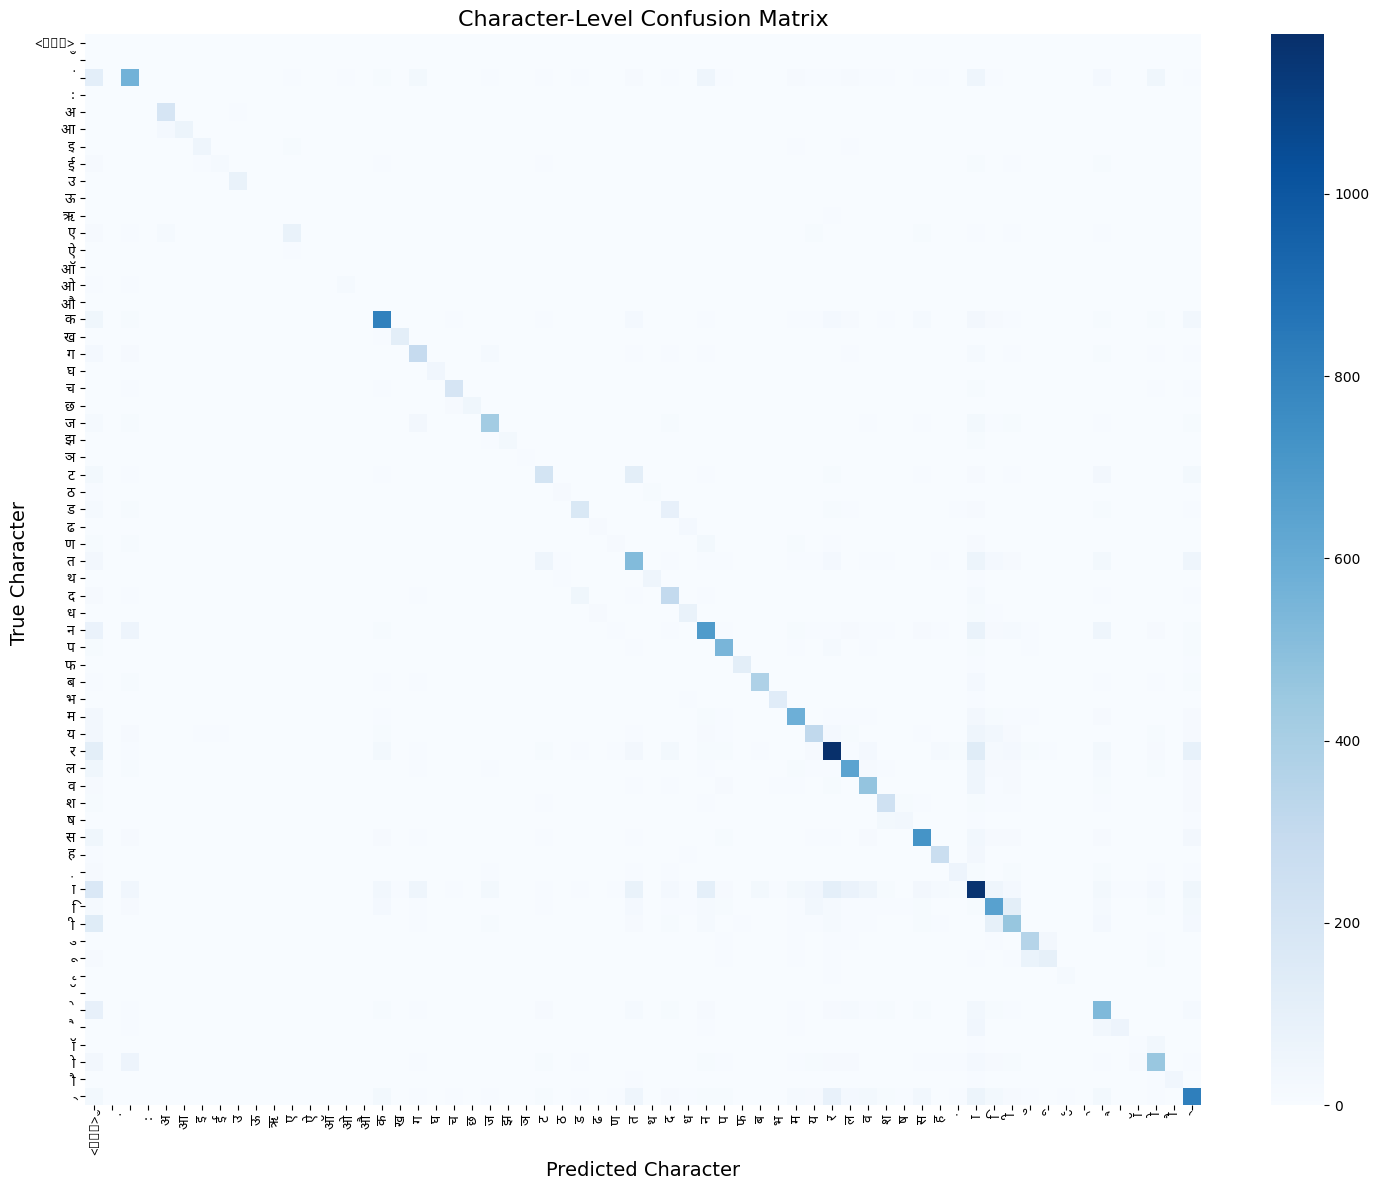

/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Devanagari.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Devanagari.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 101 (e) missing from font(s) Noto Sans Devanagari.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 111 (o) missing from font(s) Noto Sans Devanagari.
  util.ensure_matplotlib_figure(data).savefig(buf, format=self.format)
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:307: UserWarning: Glyph 115 (s) missing from font(s) Noto Sans Dev

In [77]:
wandb.login(key="b81ae278300a216ce5380e07b52d628e2dd6eb69")
wandb.init(entity="arunangshudutta218-iitm", project = 'dl_assgn_3_q_4c')

create_character_confusion_matrix(model, test_dataloader,  target_idx2char, device)